# GAN


In [ ]:
import tensorflow as tf
tf.random.set_seed(1)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import numpy as np

dataset = np.concatenate([x_train, x_test], axis=0)
dataset = np.expand_dims(dataset, -1).astype("float32") / 255

In [ ]:
BATCH_SIZE = 64

dataset = np.reshape(dataset, (-1, 28, 28, 1))
# Converte o array numpy para um objeto tensorflow
dataset = tf.data.Dataset.from_tensor_slices(dataset)
# Embara o dataset e divide em lotes para evitar vicios de aprendizado no modelo
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [ ]:
x_test.shape

(10000, 28, 28)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.activations import leaky_relu

NOISE_DIM = 150

generator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(NOISE_DIM,)),
  layers.Dense(7*7*256),
  layers.Reshape(target_shape=(7, 7, 256)),
  layers.Conv2DTranspose(256, 3, activation=leaky_relu, strides=2, padding="same"), # devido as alterações de versão foi necessário alterar os comandos para função de ativação Leaky ReLU
  layers.Conv2DTranspose(128, 3, activation=leaky_relu, strides=2, padding="same"),
  layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
])

generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,894,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,153 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,780,417 (10.61 MB)

 Trainable params: 2,780,417 (10.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
discriminator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28, 1)),
  layers.Conv2D(256, 3, activation="relu", strides=2, padding="same"),
  layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
  layers.Flatten(),
  layers.Dense(64, activation="relu"),
  layers.Dropout(0.2),
  layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 699,137 (2.67 MB)

 Trainable params: 699,137 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizerG = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
optimizerD = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5)

# classificação binária (real/sintpetica)
lossFn = keras.losses.BinaryCrossentropy(from_logits=True)

# acurácia
gAccMetric = tf.keras.metrics.BinaryAccuracy()
dAccMetric = tf.keras.metrics.BinaryAccuracy()


In [ ]:
@tf.function
def trainDStep(data):
  batchSize = tf.shape(data)[0]

  # ruido de entrada do GERADOR
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))

  # concatena dados reais e sinteticos
  y_true = tf.concat(
    [
      # dados reais são rotulados com 1
      tf.ones(batchSize, 1),
      # dados sintetico são rotulados com 0
      tf.zeros(batchSize, 1)
    ],
    axis=0
  )

  # record the calculated gradients
  with tf.GradientTape() as tape:
    # amostras sinteticas
    fake = generator(noise)
    # concatena dados reais e sinteticos
    x = tf.concat([data, fake], axis=0)
    # verifica se o descriminante reconhece
    y_pred = discriminator(x)
    # calcula a perda
    discriminatorLoss = lossFn(y_true, y_pred)

  # atualiza os pesos
  grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
  optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))

  # checa a acurácia
  dAccMetric.update_state(y_true, y_pred)

  return {
      "discriminator_loss": discriminatorLoss,
      "discriminator_accuracy": dAccMetric.result()
  }

In [ ]:
@tf.function
def trainGStep(data):
  batchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))
  y_true = tf.ones(batchSize, 1)

  with tf.GradientTape() as tape:
    y_pred = discriminator(generator(noise))
    generatorLoss = lossFn(y_true, y_pred)

  grads = tape.gradient(generatorLoss, generator.trainable_weights)
  optimizerG.apply_gradients(zip(grads, generator.trainable_weights))

  gAccMetric.update_state(y_true, y_pred)

  return {
      "generator_loss": generatorLoss,
      "generator_accuracy": gAccMetric.result()
  }

In [ ]:
from matplotlib import pyplot as plt


def plotImages(model):
    images = model(np.random.normal(size=(81, NOISE_DIM)))

    plt.figure(figsize=(9, 9))

    for i, image in enumerate(images):
        plt.subplot(9,9,i+1)
        plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
        plt.axis('off')

    plt.show();

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


E:0, Loss G:4.3885, Loss D:0.0587, Acc G:%0.06, Acc D:%97.66


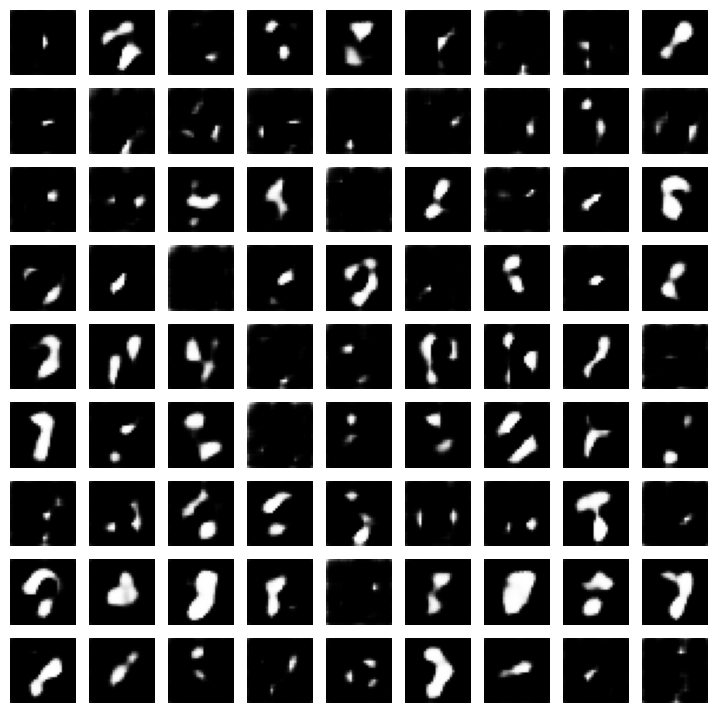

E:1, Loss G:3.1811, Loss D:0.2523, Acc G:%2.10, Acc D:%97.20
E:2, Loss G:1.6289, Loss D:0.4236, Acc G:%6.47, Acc D:%91.93


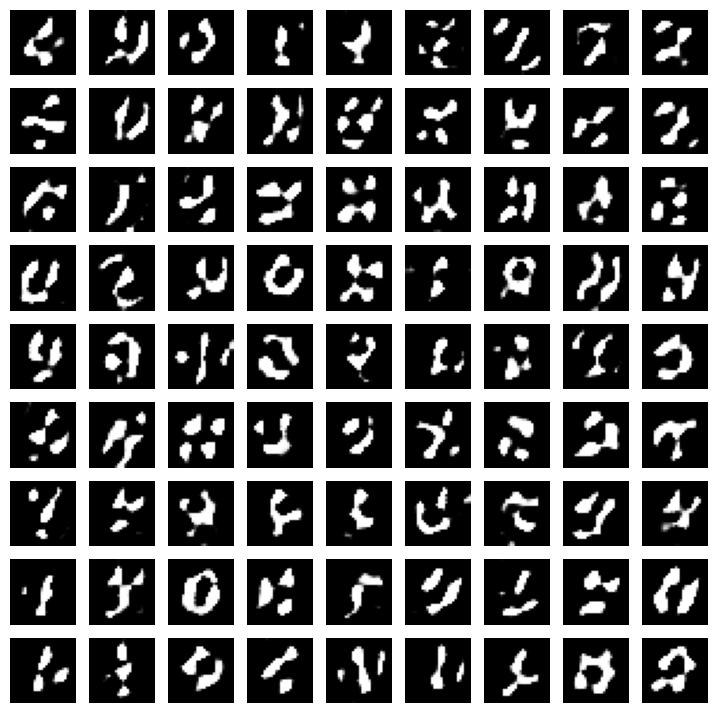

E:3, Loss G:1.7246, Loss D:0.3338, Acc G:%8.23, Acc D:%89.58
E:4, Loss G:2.0705, Loss D:0.2540, Acc G:%8.06, Acc D:%89.62


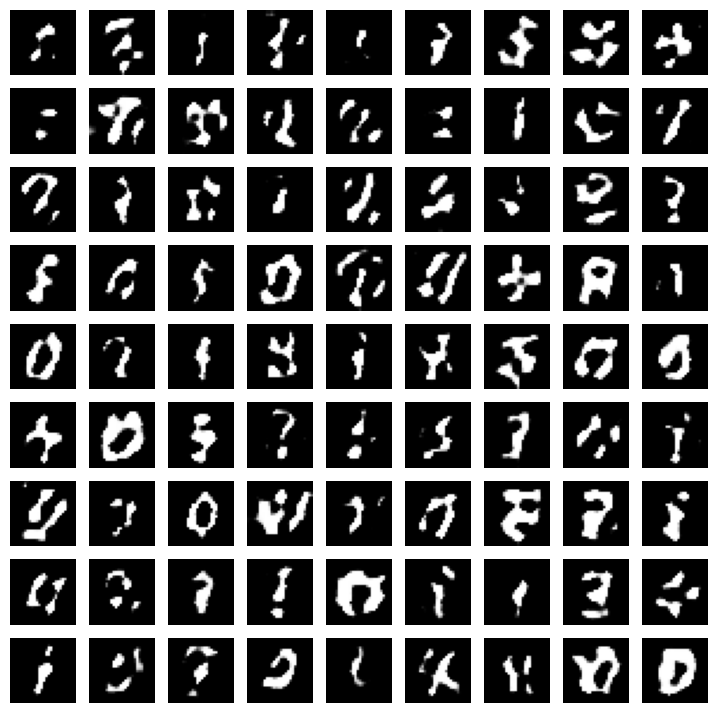

E:5, Loss G:2.0406, Loss D:0.2577, Acc G:%7.62, Acc D:%90.08
E:6, Loss G:1.7755, Loss D:0.3037, Acc G:%7.57, Acc D:%90.08


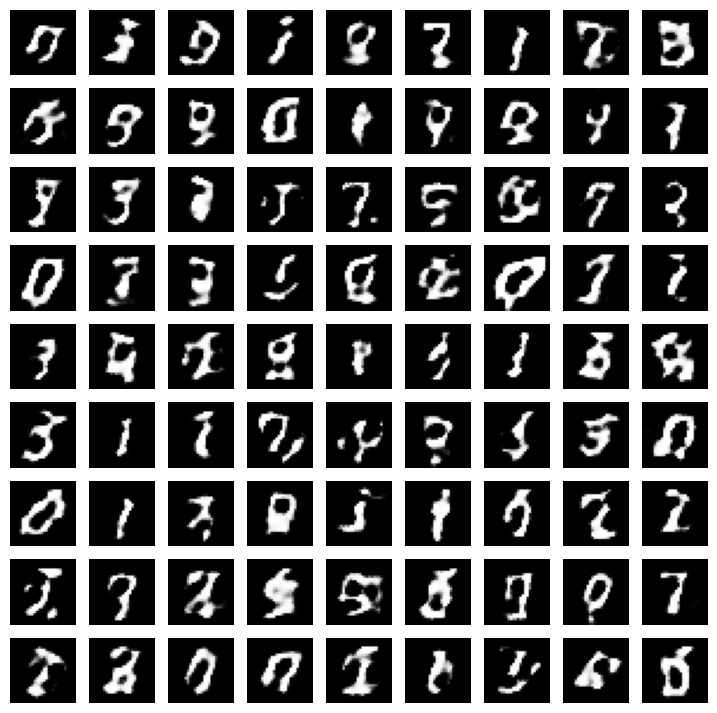

E:7, Loss G:1.7831, Loss D:0.3101, Acc G:%7.63, Acc D:%89.95
E:8, Loss G:1.8564, Loss D:0.2993, Acc G:%7.73, Acc D:%89.83


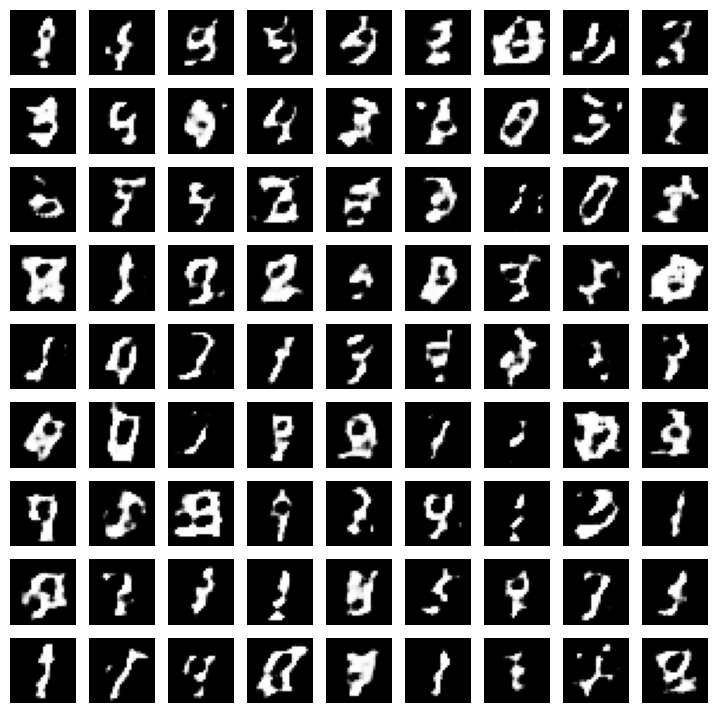

E:9, Loss G:1.9086, Loss D:0.2902, Acc G:%7.73, Acc D:%89.82
E:10, Loss G:1.9305, Loss D:0.2823, Acc G:%7.67, Acc D:%89.82


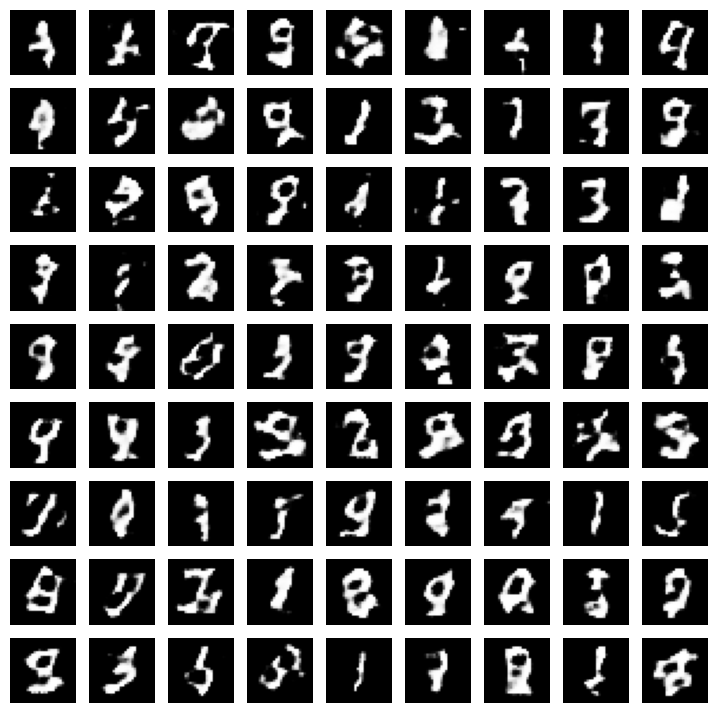

E:11, Loss G:1.9904, Loss D:0.2729, Acc G:%7.56, Acc D:%89.88
E:12, Loss G:1.9824, Loss D:0.2796, Acc G:%7.48, Acc D:%89.91


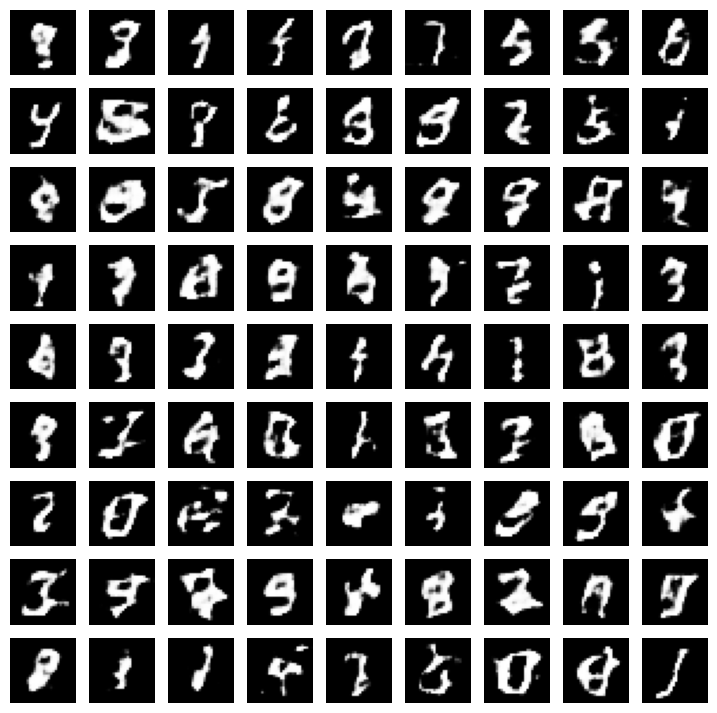

E:13, Loss G:1.9969, Loss D:0.2781, Acc G:%7.45, Acc D:%89.91
E:14, Loss G:2.0434, Loss D:0.2696, Acc G:%7.41, Acc D:%89.93


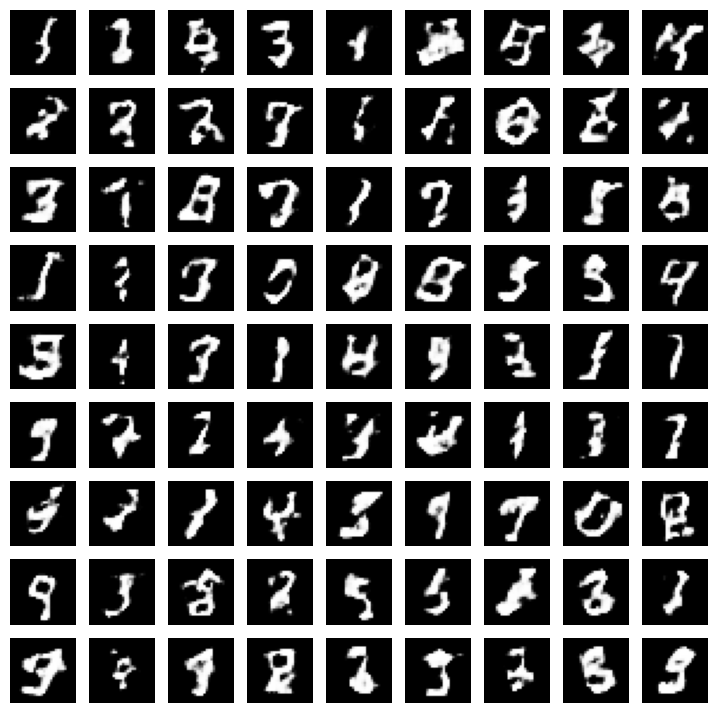

E:15, Loss G:2.0882, Loss D:0.2638, Acc G:%7.36, Acc D:%89.97
E:16, Loss G:2.1186, Loss D:0.2608, Acc G:%7.31, Acc D:%90.01


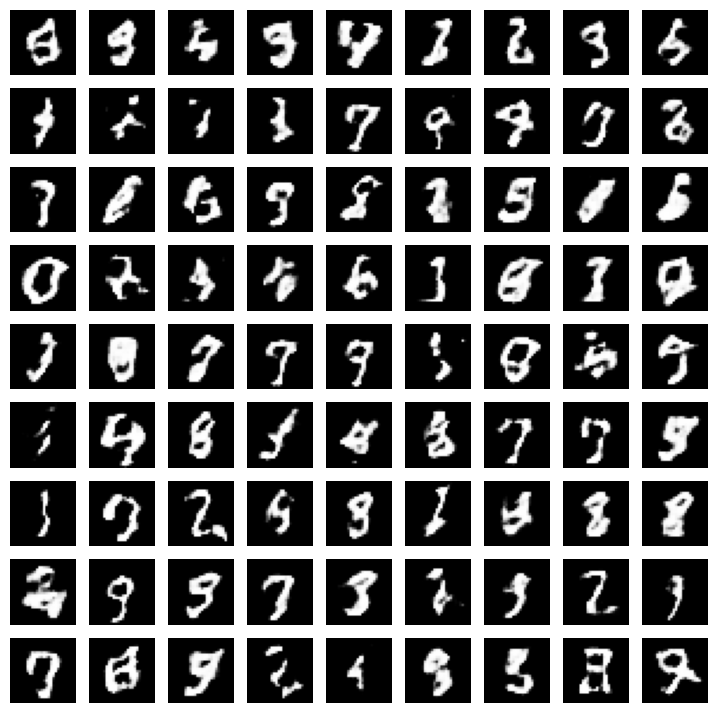

E:17, Loss G:2.1339, Loss D:0.2606, Acc G:%7.27, Acc D:%90.05
E:18, Loss G:2.1358, Loss D:0.2655, Acc G:%7.25, Acc D:%90.08


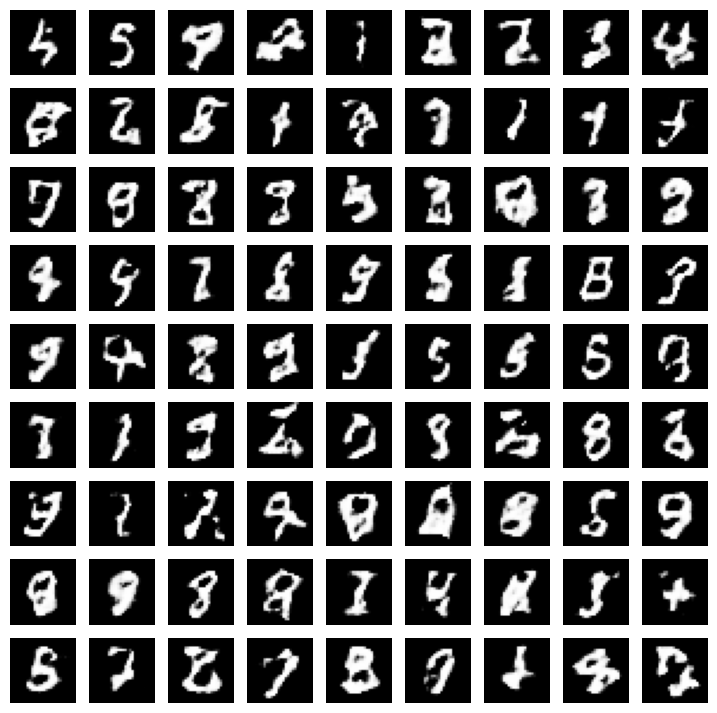

E:19, Loss G:2.1270, Loss D:0.2710, Acc G:%7.24, Acc D:%90.08
E:20, Loss G:2.1172, Loss D:0.2742, Acc G:%7.26, Acc D:%90.07


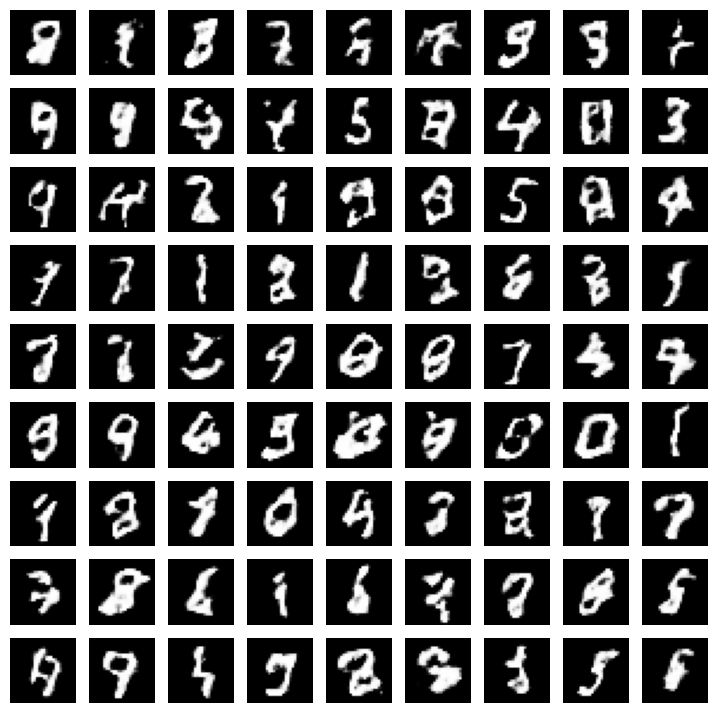

E:21, Loss G:2.1098, Loss D:0.2754, Acc G:%7.27, Acc D:%90.05
E:22, Loss G:2.1112, Loss D:0.2770, Acc G:%7.29, Acc D:%90.03


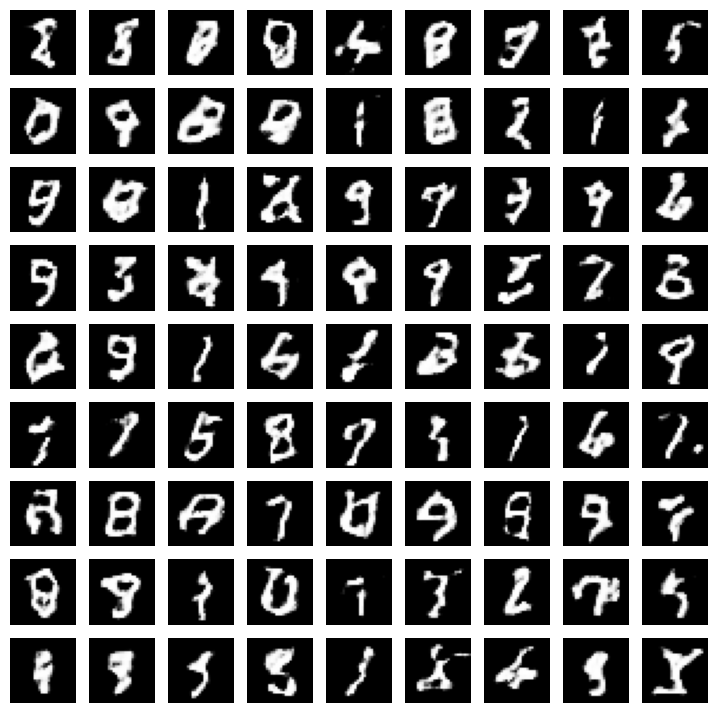

E:23, Loss G:2.1123, Loss D:0.2773, Acc G:%7.30, Acc D:%90.00
E:24, Loss G:2.1120, Loss D:0.2779, Acc G:%7.32, Acc D:%89.98


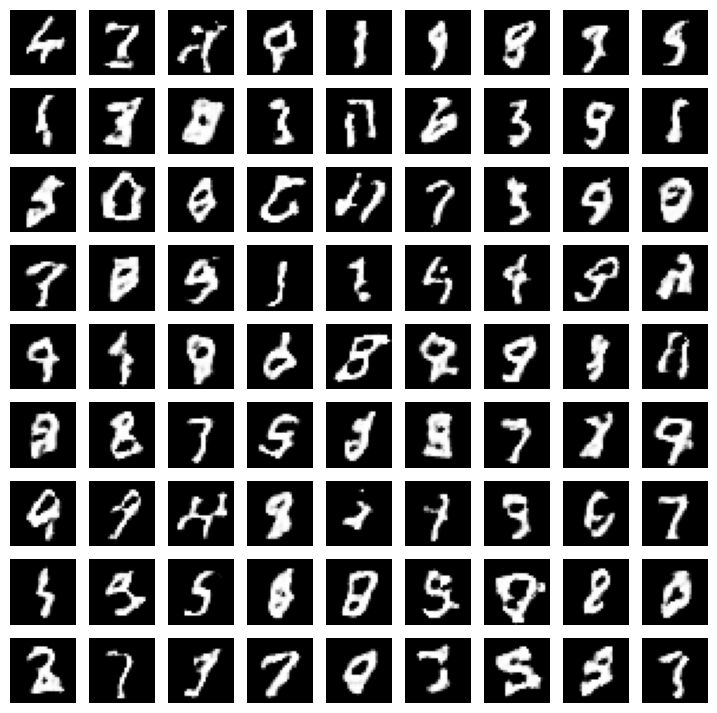

E:25, Loss G:2.1125, Loss D:0.2791, Acc G:%7.34, Acc D:%89.95
E:26, Loss G:2.1055, Loss D:0.2826, Acc G:%7.36, Acc D:%89.93


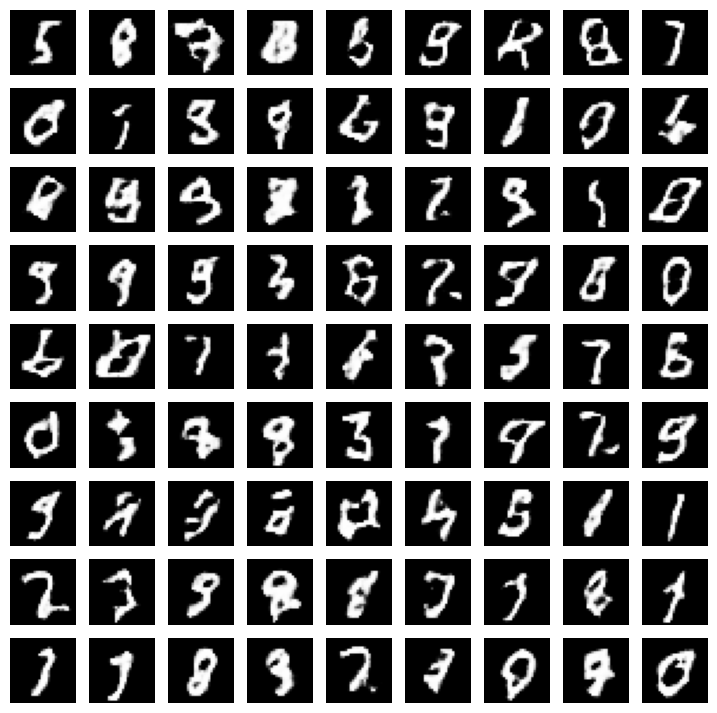

E:27, Loss G:2.1039, Loss D:0.2830, Acc G:%7.39, Acc D:%89.90
E:28, Loss G:2.1025, Loss D:0.2836, Acc G:%7.42, Acc D:%89.86


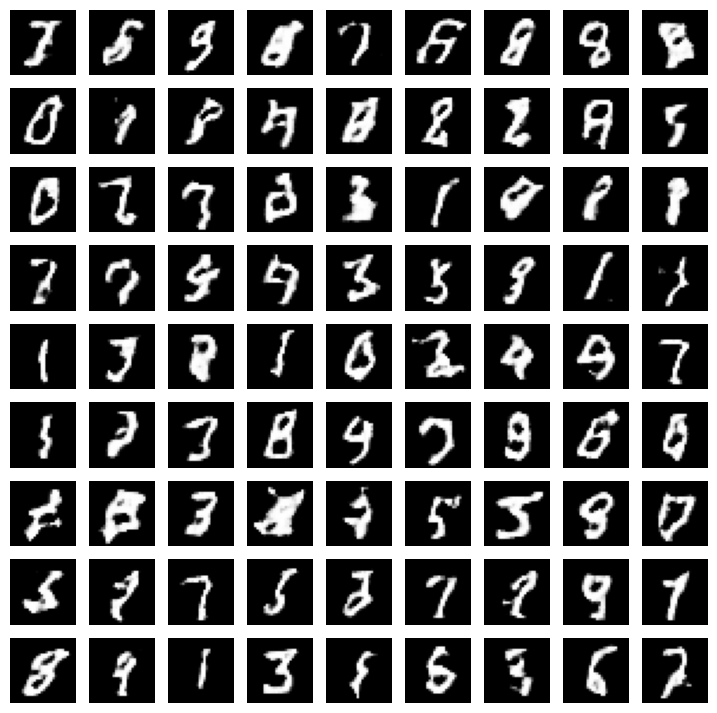

E:29, Loss G:2.1101, Loss D:0.2838, Acc G:%7.45, Acc D:%89.83


In [ ]:
# Treinamento da GAN

for epoch in range(30):

  dLossSum = 0
  gLossSum = 0
  dAccSum = 0
  gAccSum = 0
  cnt = 0

  # loop para percorrer o dataset
  for batch in dataset:

    # DISCRIMINANTE
    dLoss = trainDStep(batch)
    dLossSum += dLoss['discriminator_loss']
    dAccSum += dLoss['discriminator_accuracy']

    # GERADOR
    gLoss = trainGStep(batch)
    gLossSum += gLoss['generator_loss']
    gAccSum += gLoss['generator_accuracy']

    # contador
    cnt += 1

  # log do treinamento
  print("E:{}, Loss G:{:0.4f}, Loss D:{:0.4f}, Acc G:%{:0.2f}, Acc D:%{:0.2f}".format(
      epoch,
      gLossSum/cnt,
      dLossSum/cnt,
      100 * gAccSum/cnt,
      100 * dAccSum/cnt
  ))

  if epoch % 2 == 0:
    plotImages(generator)

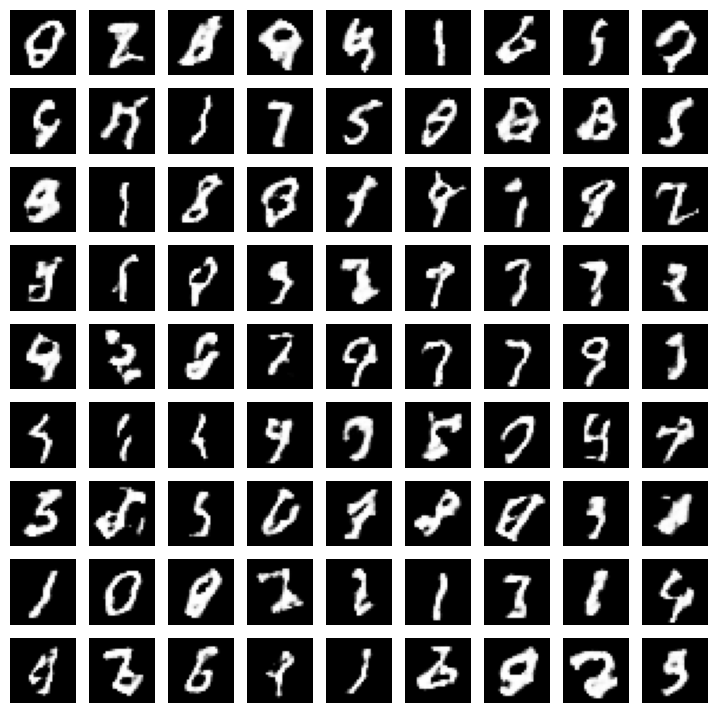

In [ ]:
# Gerando imagens com o modelo treinado
images = generator(np.random.normal(size=(81, NOISE_DIM)))

from matplotlib import pyplot as plt

plt.figure(figsize=(9, 9))

for i, image in enumerate(images):
    plt.subplot(9,9,i+1)
    plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
    plt.axis('off')

plt.show();